# GENRE CLASSIFICATION MODEL TRAINING

_Why do I care about genre classification?_

My main task is neural style transfer between a musical piece (the content) and an auditory ambience (the style). Genre classification is a means to model the timbral and acoustic qualities of a musical piece (as both are relevant factors in determining genre), and are key aspects I want to modify with neural style transfer.

---

For genre classification, I have trained 2 types of models:

1. CNN using mel-frequency cepstral coefficients (MFCCs) as input
2. CNN using melspectrograms as input

The reasons for each are given in the respecting training sections.

---

DATASET:

- GTZAN Dataset for Music Classification: <br> https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

---

Importing dependencies...

In [1]:
import import_ipynb
N = import_ipynb.NotebookLoader(path=['.'])
N.load_module("ImportsForGenreClassification")
from ImportsForGenreClassification import *

importing Jupyter notebook from .\ImportsForGenreClassification.ipynb
importing Jupyter notebook from .\ImportsForAudioHandling.ipynb
importing Jupyter notebook from .\ImportsForDataHandling.ipynb
importing Jupyter notebook from .\ImportsForModelHandling.ipynb


# Important constants and variables

In [20]:
# Dictionary of strings to help easily add ID markers to file names:
id_strings = {'melspectrogram_model': '_sr-22050_n_fft-1024_hop_length-256_n_mels-384', 'mfcc_model': '_sr-22050_n_fft-1024_hop_length-256_n_mfcc-40'}
# Important file and folder names:
annotations_file_30_secs  = 'storage/data/features_30_sec.csv'
annotations_file_3_secs  = 'storage/data/features_3_sec.csv'
audio_folder = 'storage/data/genres_original'
melspectrogram_storage_file_name = 'storage/melspectrograms/melspectrograms' + id_strings['melspectrogram_model'] + '.npy'
mfcc_storage_file_name = 'storage/mfccs/mfccs' + id_strings['mfcc_model'] + '.npy'
n_classes = None # Assigned later

# Obtaining annotations
## Picking the relevant data
Reading the relevant CSV file...

In [3]:
df = pd.read_csv(annotations_file_30_secs, header=0)
df.head(5)

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


Renaming file names to include the subfolders in which they exist (so they can accessed more easily using the column 'filename')...

In [4]:
filenames_with_subfolders = [filename.split('.')[0] + '/' + filename for filename in df['filename']]

**NOTE**: _Each file is stored in the folder with its genre name, and each file is named in the format_: `<genre>.<id>.wav`.

---

Picking only the relevant columns and renaming them for readability...

In [5]:
# NOTE: Always run the previous cell before running this one!
df = pd.DataFrame(data={'TRACK':filenames_with_subfolders, 'GENRE':df['label']})
df.head(5)

,TRACK,GENRE
0,blues/blues.00000.wav,blues
1,blues/blues.00001.wav,blues
2,blues/blues.00002.wav,blues
3,blues/blues.00003.wav,blues
4,blues/blues.00004.wav,blues


**NOTE: Corrupted file**:

When working on the project, the file "jazz/jazz.00054.wav" was found to be corrupted, hence could not be processed. Hence, we shall remove it from the dataset for ensuring the later outputs when gathering the data are more presentable (i.e. without warning messages).

In [6]:
df.drop(df.loc[df['TRACK'] == 'jazz/jazz.00054.wav'].index.tolist(), axis=0, inplace=True)

## Listing the available genres

In [7]:
print(df['GENRE'].unique().tolist())

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


## Creating integer target values
Converting targets to integer values to enable 1-hot encoding later (which is necessary to handle multiclass classification)...

In [8]:
genre_to_integer_map = {}
for i, genre in enumerate(df['GENRE'].unique()):
    genre_to_integer_map[genre] = i

# Seeing the mapping:
for key in genre_to_integer_map: print(f'{key}: {genre_to_integer_map[key]}')

blues: 0
classical: 1
country: 2
disco: 3
hiphop: 4
jazz: 5
metal: 6
pop: 7
reggae: 8
rock: 9


**NOTE**: This mapping has been stored in `ImportsForGenreClassification.ipynb` and is shown here only for reference.

---

Creating a target row...

In [9]:
targets = []
for genre in df['GENRE']: targets.append(genre_to_integer_map[genre])
df['TARGET'] = targets

# Storing total number of target classes:
n_classes = len(df['TARGET'].unique())

# Showing 5 random rows:
df.sample(n=5)

,TRACK,GENRE,TARGET
285,country/country.00085.wav,country,2
657,metal/metal.00057.wav,metal,6
193,classical/classical.00093.wav,classical,1
344,disco/disco.00044.wav,disco,3
124,classical/classical.00024.wav,classical,1


Saving the above obtained data frame as CSV for future use...

In [10]:
df.to_csv('storage/data/features_30_sec_modified.csv')

# Training for MFCCs

## Preliminary discussion
**Mel-frequency cepstrum coefficient (MFCC)**:

The mel frequency cepstral coefficients (MFCCs) of an audio signal are a small set of features (usually about 10–20) which describe the overall shape of the spectral envelope (i.e. the overall distribution of a signal's power over its frequency). More precisely, we have the following chain of concepts:

- Power spectral density describes how the power of a signal or time series is distributed over frequency
- Mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound
- Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC

> REFERENCES:
> - https://medium.com/@derutycsl/intuitive-understanding-of-mfccs-836d36a1f779
> - https://en.wikipedia.org/wiki/Mel-frequency_cepstrum
> - https://en.wikipedia.org/wiki/Spectral_density#Power_spectral_density

**Relevant questions**...

_Why bother MFCC?_

Generally, the essential music dimension used in content-based approaches is timbre. Timbre can be defined as "the character or quality of a musical sound or voice as distinct from its pitch and intensity". It depends on the perception of the quality of sounds, which is related to the used musical instruments, with possible audio effects, and to the playing techniques. In the field of speech recognition, the mel-frequency cepstral coefficients (MFCCs) have been widely used to model important characteristics in speech. Since modelling speech characteristics and timbre are similar, the use of MFCCs has been extended with success in the field of music similarity (e.g. genre classification, which depends to an extent on timbre).

> REFERENCE: de Leon, F., Martinez, K. (2012). 'Enhancing Timbre Model Using MFCC And Its Time Derivatives For Music Similarity Estimation'. 20th European Signal Processing Conference (EUSIPCO 2012)

**NOTE**: Whether MFCCs models timbre is a somewhat open question, but it is reasonable to assume that they do to some extent.

_Why do I care about timbre?_

I aim to transfer the timbral and acoustic qualities of an ambience-type audio to a musical piece. Hence, I care about timbre and about a model that can - to some extent - model timbral and acoustic qualities of sound and music especially (we shall use a genre classifier to achieve such modelling).

## Preparing the data for training
### Deciding the settings
Certain settings (such as maximum number of frames) is determined based on the average number of frames per piece. Other settings, such as the window length for which to perform fast Fourier transforms (the respective value denoted by `n_fft`) and hop length, are decided based on commonly-used defaults. Since I have no means right now to make an educated judgement about these parameters, I choose to follow the common practices for now.

As for the number of MFCCs to evaluate (`n_mfcc`), I was unable to obtain a non-arbitrary number (apart from the fact that the commonly used range in speech recognition was 13-40). I tried training for 10 epochs with `n_mfcc` as 15, 20, 40 and 60. Clearly, the more the `n_mfcc` value, the greater the number of parameters that need to be trained, and if the dataset is not large enough, the risk of overfitting becomes greater. Furthermore, the model coverged fastest for `n_mfcc = 40` and slowest for `n_mfcc = 15`. However, the model was converging for all the tested `n_mfcc` values. Hence, the criteria to decide `n_mfcc` are:

- Is the model overfitting for the given `n_mfcc` value?
- Are lower values similarly effective (even if the model converges more slowly)?

---

**RESULTS FOR DIFFERENT VALUES OF** `n_mffc`:

- `n_mfcc = 15` (50 epochs)
    - Slow convergence
    - Training accuracy plateaus at around 87%
    - Validation accuracy plateaus at around 75%
- `n_mfcc = 20` (60 epochs)
    - Moderate convergence (reached 80% training accuracy in 20 epochs)
    - Training accuracy plateaus at around 95%
     - Validation accuracy plateaus at around 78%
- `n_mfcc = 30` (50 epochs)
    - Training accuracy reaches around 96%
    - Validation plateaus at around 75%
- `n_mfcc = 40` (40 epochs)
    - Relatively fast convergence (reached 80% training accuracy in 10 epochs)
    - Training accuracy reaches around 98%
    - Validation accuracy plateaus at around 78%
- `n_mfcc = 60` (30 epochs)
    - Very fast convergence (reached 90% training accuracy in 10 epochs)
    - Training accuracy reaches around 99%
    - Validation accuracy plateaus at around 77%

**NOTE: Random variation in performance**: Note that in training and validation, there are certain factors that can affect small, specific differences: (1) initial random weights of the model, (2) shuffling of training and validation data. These factors are randomised, so we expect a small amount of random variation in training outcomes. Hence, we shall look for only significantly different performances (~5% difference in accuracy) rather than 1-2 percent changes.

---

Based on the above results, we have reason to conclude the following:

- `n_mfcc = 60` results in overfitting (too many parameters relative to data)
- `n_mfcc = 40` results similar or better results as other parameters but with fewer epochs than lower values of `n_mfcc`
- `n_mfcc = 60` is practically identical to `n_mfcc = 40` in terms of final performance (though the former converges slightly faster)
- `n_mfcc = 20` or `n_mfcc = 30` plateauing in training may mean that they omit some features that could be relevant for classification

The safest and most efficient option so far is `n_mfcc = 40`. Furthermore, with enough iterations, `n_mfcc = 40` was observed to achieve slightly better validation accuracy more consistently than lower values.

### Obtaining MFCCs for each track

<h4 style="color:blue"> DEMO: The array of MFCCs for each track </h4>

In [21]:
# DEMO FUNCTION:
def get_all_mfccs_DEMO(df, audio_folder, mfcc_storage_file_name=mfcc_storage_file_name, n_fft=1024, hop_length=256, sr=22050, n_mfcc=40):
    all_mfccs = []
    prev_i, max_i = 0, float(len(df['TRACK']))
    for i, track in enumerate(df['TRACK']):
        # Progress bar with maximum length of 12 dots:
        if i // (max_i / 12) > prev_i // (max_i / 12):
            print('.', end='')
        prev_i = i
        #________________________
        signal, sr = librosa.load(audio_folder + '/' + track, sr=sr)
        mfccs = librosa.feature.mfcc(y=signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
        
        # Append MFCCs array to the list:
        all_mfccs.append(mfccs)
    print('\nDone')
    return all_mfccs

#================================================
# Running the demo function
all_mfccs = get_all_mfccs_DEMO(df, audio_folder)

#================================================
# Inspecting the dimensions of each file's melspectrogram...
print('\nSTATISTICS FOR FRAMES PER AUDIO FILE')
dims = []
for mfccs in all_mfccs:
    dims.append(mfccs.shape)
dims = np.array(dims)

# We know 1st dimension (`n_mels`) is the same for all. Checking the 2nd dimension:
print(f'Max: {max(dims[:, 1])}\nMin: {min(dims[:, 1])}\nMean: {np.mean(dims[:, 1])}\nStd.: {np.std(dims[:, 1])}')

...........
Done

STATISTICS FOR FRAMES PER AUDIO FILE
Max: 2640
Min: 2579
Mean: 2586.937937937938
Std.: 6.868284027151889


We shall use the above results to decide the parameters for data padding and truncating in the main data-gathering/storing function.

#### MAIN: Gathering equally dimensioned MFCCs for each track

The main data gathering function...

In [12]:
all_mfccs, audio_params = get_all_mfccs(df, audio_folder, mfcc_storage_file_name, n_fft=1024, hop_length=256, n_mfcc=40, n_frames=2587)

Regenerate MFCCs? No


In [13]:
print('Shape of MFCCs dataset:', all_mfccs.shape)
print('Audio parameters:')
for key in audio_params: print(f'{key} = {audio_params[key]}')

Shape of MFCCs dataset: (999, 40, 2587)
Audio parameters:
n_fft = 1024
hop_length = 256
sr = 22050
n_frames = 2587
n_mfcc = 40


Checking random MFCCs to help verify that the data has been properly obtained...

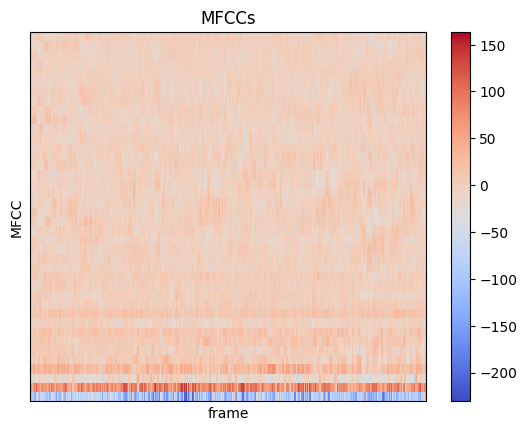

In [19]:
display_random(all_mfccs, 'MFCCs', 'frame', 'MFCC')

### Obtaining datasets fit for training and testing¶

In [14]:
data_params, data_and_labels, train_dataset, validation_dataset = get_data(df, all_mfccs, n_classes=10, segments_per_file=6, validation_start=0.9, batch_size=32)

# Printing data parameters for reference:
print('\nData parameters:')
for key in data_params: print(f'{key} = {data_params[key]}')

Training data shape = (5395, 40, 431), Validation data shape = (599, 40, 431)

Data parameters:
segments_per_file = 6
validation_start = 0.9
n_classes = 10
batch_size = 32


Deleting the previous MFCCs array (now no longer needed) to free up the RAM...

In [15]:
del(all_mfccs)

Checking random a MFCC array to help verify that the data has been properly obtained...

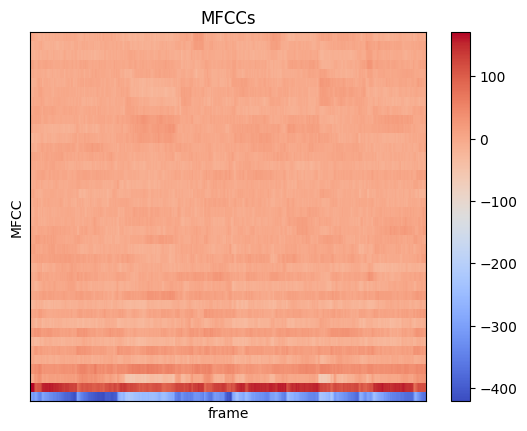

In [37]:
display_random(data_and_labels['train_data'], 'MFCCs', 'frame', 'MFCC')

## Building the CNN for handling MFCCs
Calling function to generate CNN model (function defined in `ImportsForModelBuilding.ipynb`) and viewing model parameters...

In [16]:
input_shape = (audio_params['n_mfcc'], audio_params['n_frames'] // data_params['segments_per_file'], 1)
model = get_cnn_5_sec_mfcc(input_shape=input_shape, lr=0.001) # NOTE: Number of target classes has been defined as 10 by default in the function `get_model`
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ identity (Identity)                  │ (None, 40, 431, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 40, 431, 1)          │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 38, 429, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 19, 215, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 17, 213, 32)         │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 9, 107, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 106, 32)          │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 53, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 52, 32)           │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 26, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 1, 25, 32)           │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 1, 13, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1, 13, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 13, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          26,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,422 (193.05 KB)

 Trainable params: 49,356 (192.80 KB)

 Non-trainable params: 66 (264.00 B)

Training the model (check logs for training information)...

In [ ]:
# CALLBACKS

# Logging training and validation per epoch:
csv_logger = keras.callbacks.CSVLogger('storage/trainingLogs/genreClassificationTraining' + id_strings['mfcc_model'] + '.log', separator=',', append=True)

# Saving best model's weights so far every epoch:
checkpoint_path = 'storage/trainedModelWeights/genreClassificationTrainedModelWeight' + id_strings['mfcc_model'] + '.weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, save_weights_only=True, verbose=0, save_freq='epoch')

# Callback to reduce learning rate in case of plateau in validation accuracy:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=0, mode='max', min_delta=0.005, cooldown=0, min_lr=0.0)
'''
NOTE ON ARGUMENTS:
- monitor (String): Quantity to be monitored
- factor (Float): Factor by which the learning rate will be reduced. new_lr = lr * factor
- patience (Integer): Number of epochs with no improvement after which learning rate will be reduced
- verbose (Integer): 0: quiet, 1: update messages
- mode (String): One of {'auto', 'min', 'max'}
    - In 'min' mode, the learning rate will be reduced when the quantity monitored has stopped decreasing
    - In 'max' mode it will be reduced when the quantity monitored has stopped increasing
    - In 'auto' mode, the direction is automatically inferred from the name of the monitored quantity
- min_delta (Float): Threshold for measuring the new optimum, to only focus on significant changes
- cooldown (Integer): Number of epochs to wait before resuming normal operation after the learning rate has been reduced.
- min_lr (Float): Lower bound on the learning rate
'''

#================================================
# TRAINING MODEL

model.fit(train_dataset,
          epochs=30,
          batch_size=data_params['batch_size'],
          validation_data=validation_dataset,
          verbose=True,
          callbacks=[csv_logger, checkpoint, reduce_lr_on_plateau])

# Save the final model:
save_model(model, 'storage/trainedModelWeights/genreClassificationTrainedModelWeights' + id_strings['mfcc_model'] + '.npy')

Saving the weights of the best model (as saved in the checkpoint)...

In [19]:
save_model(checkpoint.model, 'storage/trainedModelWeights/genreClassificationTrainedModelWeights' + id_strings['mfcc_model'] + '_bestValidationAccuracy.npy')

Reading history through logs (a more reliable and customisable method of seeing results)...

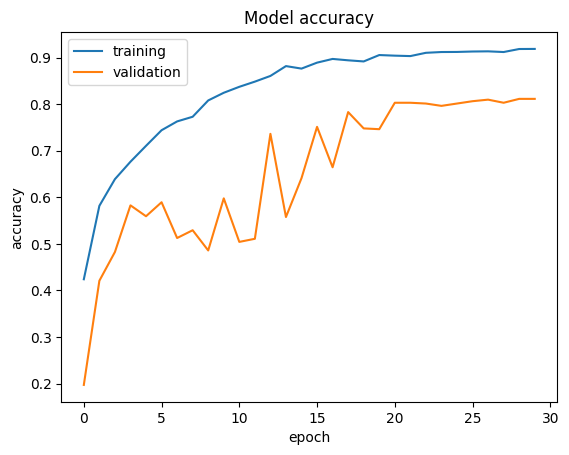

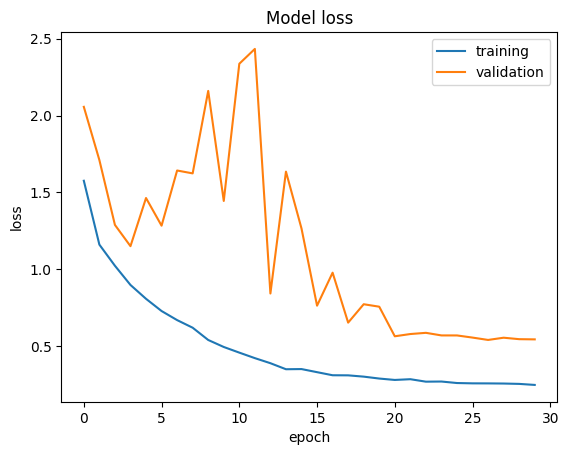

In [21]:
# NOTE: Give following argument as `csv_logger.csv_file.name` if you want to use the recently saved training history
history = read_logs('storage/trainingLogs/genreClassificationTraining' + id_strings['mfcc_model'] + '.log')
plot_model_history(history) # Function available in `ImportsForModelHandling.ipynb`

# Training for melspectrograms
## Preliminary discussion
The way we hear frequencies in sound is known as 'pitch'. It is a subjective impression of the frequency. So a high-pitched sound has a higher frequency than a low-pitched sound. Humans do not perceive frequencies linearly. We are more sensitive to differences between lower frequencies than higher frequencies. For example, the pair at 100Hz and 200Hz will sound further apart than the pair at 1000Hz and 1100Hz, even if the actual frequency difference between each pair is the same (100 Hz); you will hardly be able to distinguish between the pair at 10000Hz and 10100Hz. _
However, this may seem less surprising if we realize that the 200Hz frequency is actually double the 100Hz, whereas the 10100Hz frequency is only 1% higher than the 10000Hz frequency.

This is how humans perceive frequencies; we hear them on a logarithmic scale rather than a linear scale. The mel scale was developed to take this into account by conducting experiments with a large number of listeners. It is a scale of pitches such that each would be unit is judged by human listeners to be equal in pitch distance from the next.

> REFERENCE: https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505

_Why use melspectrograms?_

Modelling audio based on how humans perceive audio is a practical starting point to try to model audio recognition according to human needs (e.g. genre, key signature, etc.). Instead of frequencies, we consider mel bands that convey the most significant frequencies to a human ear and their relationships between each other with respect to human perception; this allows us to reduce data while preserving most or all the relevant information needed for audio recognition tasks.

**NOTE**: We could also scale signal power with decibel (a logarithmic scale) instead of amplitude (a linear scale), the former modelling human perception more closely. However, I shall not do this because I intend eventually to reconstruct the audio signals from the melspectrograms passed and modified through my models, and I found that converting the signal power to decibel scale led to too much information loss and led to poor signal reconstruction.

## Preparing the data for training
### Deciding the settings
Certain settings (such as maximum number of frames) is determined based on the average number of frames per piece. Other settings, such as the window length for which to perform fast Fourier transforms (the respective value denoted by `n_fft`) and hop length, are decided based on commonly-used defaults. Since I have no means right now to make an educated judgement about these parameters, I choose to follow the common practices for now. As for the number of mel bands to evaluate for, I used the lowest number I could find that could allow a suitably high-quality reconstruction to the original audio (I arrived at 512 mel bands being as good as practically possible, 256 mel bands being almost good enough with a some loss; hence, I chose the mid-point, i.e. 384 mel bands to get a balance between efficiency and quality). Note that the mel bands were chosen with respect to hop length 256 and FFT window length 1024.

### Obtaining melspectrograms for each track

<h4 style="color:blue"> DEMO: Melspectrograms for each track </h4>

**NOTE ON CODE'S REDUNDANCY**: We do not need to inspect the melspectrograms to figure out the number of frames needed per audio file, since it would be the same as it was for MFCCs (since the sampling rate and hop length are kept the same). But I am presenting the following code just for completeness, so that each section (i.e. each of "Training for MFCCs" and "Training for melspectrograms") is self-contained.

In [15]:
# DEMO FUNCTION:
def get_all_melspectrograms_DEMO(df, audio_folder, n_fft=1024, hop_length=256, sr=22050, n_mels=384):
    all_melspectrograms = []
    prev_i, max_i = 0, float(len(df['TRACK']))
    for i, track in enumerate(df['TRACK']):
        # Progress bar with maximum length of 12 dots:
        if i // (max_i / 12) > prev_i // (max_i / 12):
            print('.', end='')
        prev_i = i
        #________________________
        # Time-domain signal:
        signal, sr = librosa.load(audio_folder + '/' + track, sr=sr)
        # Short-time Fourier transform:
        stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
        # Spectrogram:
        spectrogram = np.abs(stft)
        # Melspectrogram:
        melspectrogram = librosa.feature.melspectrogram(S=spectrogram, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        
        # Append MFCCs array to the list:
        all_melspectrograms.append(melspectrogram)
    print('\nDone')
    return all_melspectrograms

#================================================
# Running the demo function:
all_melspectrograms = get_all_melspectrograms_DEMO(df, audio_folder)

#================================================
# Inspecting the dimensions of each file's melspectrogram...
print('\nSTATISTICS FOR FRAMES PER AUDIO FILE')
dims = []
for melspectrogram in all_melspectrograms:
    dims.append(melspectrogram.shape)
dims = np.array(dims)

# We know 1st dimension (`n_mels`) is the same for all. Checking the 2nd dimension:
print(f'Max: {max(dims[:, 1])}\nMin: {min(dims[:, 1])}\nMean: {np.mean(dims[:, 1])}\nStd.: {np.std(dims[:, 1])}')

...........
Done

STATISTICS FOR FRAMES PER AUDIO FILE
Max: 2640
Min: 2579
Mean: 2586.937937937938
Std.: 6.868284027151889


We shall use the above results to decide the parameters for data padding and truncating in the main data-gathering/storing function.

### MAIN: Gathering equally dimensioned melspectrograms for each track

_Why bother with equally dimensioned melspectrograms?_ Simply because they can be turned to arrays and thus be made easier to handle, store and process. We shall be segmenting the melspectrograms before training, so we are bound to get equally sized melspectrograms for training (matrix-based models such as neural networks cannot handle uneven dimensionality), but ensuring equal dimensions before just makes preprocessing more efficient.

The main data gathering function...

In [10]:
all_melspectrograms, audio_params = get_all_melspectrograms(df, audio_folder, melspectrogram_storage_file_name, n_fft=1024, hop_length=256, n_mels=384, n_frames=2587)

Regenerate melspectrograms? No


---

In case the melspectrograms dataset was too large, I used the following code to save it...
```python
f = open(file_name, 'wb')
pickle.dump({'all_melspectrograms':all_melspectrograms, 'params':audio_params}, f, protocol=-1)
f.close()
```
To load it back when saved in the above manner, do not call `get_all_melspectrograms` but instead do...

```python
f = open(file_name, 'rb')
all_melspectrograms, audio_params = pickle.load(f).values()
f.close()
```

**SIDE NOTE**: I used the file name `storage/melspectrograms/melspectrograms_sr-22050_n_fft-1024_hop_length-256_n_mels-512.txt`.

---

In [11]:
print('Shape of melspectrograms dataset:', all_melspectrograms.shape)
print('Audio parameters:')
for key in audio_params: print(f'{key} = {audio_params[key]}')

Shape of melspectrograms dataset: (999, 384, 2587)
Audio parameters:
n_fft = 1024
hop_length = 256
sr = 22050
n_frames = 2587
n_mels = 384


Checking random melspectrograms to help verify that the data has been properly obtained...

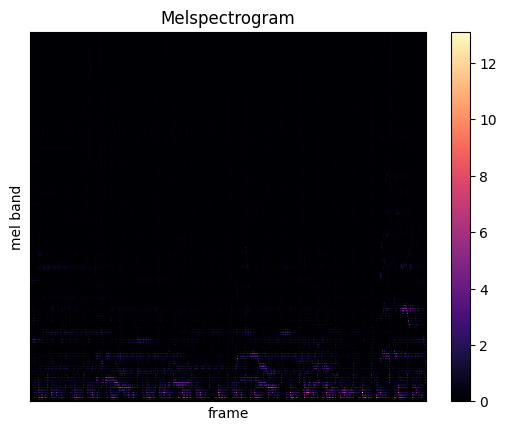

In [12]:
display_random(all_melspectrograms, 'Melspectrogram', 'frame', 'mel band')

### Obtaining datasets fit for training and testing

In [13]:
data_params, data_and_labels, train_dataset, validation_dataset = get_data(df, all_melspectrograms, n_classes=10, segments_per_file=6, validation_start=0.9, batch_size=32)

# Printing data parameters for reference:
print('\nData parameters:')
for key in data_params: print(f'{key} = {data_params[key]}')

Training data shape = (5395, 384, 431), Validation data shape = (599, 384, 431)

Data parameters:
segments_per_file = 6
validation_start = 0.9
n_classes = 10
batch_size = 32


Deleting the previous melspectrogram array (now no longer needed) to free up the RAM...

In [14]:
del(all_melspectrograms)

Checking random a melspectrogram to help verify that the data has been properly obtained...

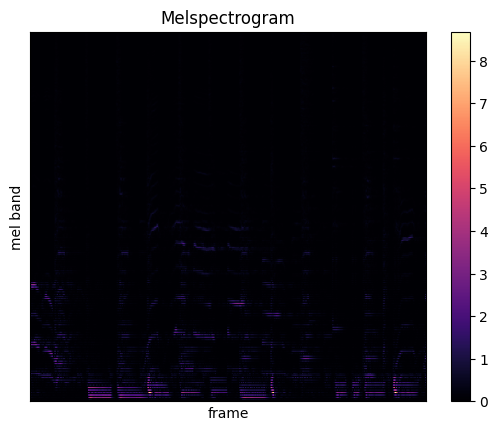

In [15]:
display_random(data_and_labels['train_data'], 'Melspectrogram', 'frame', 'mel band')

## Building the CNN for handling melspectrograms
Calling function to generate CNN model (function defined in `ImportsForModelBuilding.ipynb`) and viewing model parameters...

In [22]:
input_shape = (audio_params['n_mels'], audio_params['n_frames'] // data_params['segments_per_file'], 1)
model = get_cnn_5_sec_melspectrogram_v2(input_shape=input_shape, lr=0.001) # NOTE: Number of target classes has been defined as 10 by default in the function `get_model`
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ identity_3 (Identity)                │ (None, 384, 431, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 384, 431, 1)         │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 383, 430, 32)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 192, 215, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 191, 214, 32)        │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 96, 107, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 95, 106, 32)         │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 48, 53, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 47, 52, 32)          │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 24, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 23, 25, 32)          │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 12, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 11, 12, 32)          │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 5, 5, 32)            │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 4, 4, 32)            │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 4, 4, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 62,670 (244.80 KB)

 Trainable params: 62,604 (244.55 KB)

 Non-trainable params: 66 (264.00 B)

Training the model (check logs for training information)...

In [ ]:
# CALLBACKS

# Logging training and validation per epoch:
csv_logger = keras.callbacks.CSVLogger('storage/trainingLogs/genreClassificationTraining' + id_strings['melspectrogram_model'] + '.log', separator=',', append=True)

# Saving best model's weights so far every epoch:
checkpoint_path = 'storage/trainedModelWeights/genreClassificationTrainedModelWeight' + id_strings['melspectrogram_model'] + '.weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, save_weights_only=True, verbose=0, save_freq='epoch')

# Callback to reduce learning rate in case of plateau in validation accuracy:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=0, mode='max', min_delta=0.005, cooldown=0, min_lr=0.0)
'''
NOTE ON ARGUMENTS:
- monitor (String): Quantity to be monitored
- factor (Float): Factor by which the learning rate will be reduced. new_lr = lr * factor
- patience (Integer): Number of epochs with no improvement after which learning rate will be reduced
- verbose (Integer): 0: quiet, 1: update messages
- mode (String): One of {'auto', 'min', 'max'}
    - In 'min' mode, the learning rate will be reduced when the quantity monitored has stopped decreasing
    - In 'max' mode it will be reduced when the quantity monitored has stopped increasing
    - In 'auto' mode, the direction is automatically inferred from the name of the monitored quantity
- min_delta (Float): Threshold for measuring the new optimum, to only focus on significant changes
- cooldown (Integer): Number of epochs to wait before resuming normal operation after the learning rate has been reduced.
- min_lr (Float): Lower bound on the learning rate
'''

#================================================
# TRAINING MODEL

model.fit(train_dataset,
          epochs=30,
          batch_size=data_params['batch_size'],
          validation_data=validation_dataset,
          verbose=True,
          callbacks=[csv_logger, checkpoint, reduce_lr_on_plateau])

# Save the final model:
save_model(model, 'storage/trainedModelWeights/genreClassificationTrainedModelWeights' + id_strings['melspectrogram_model'] + '.npy')

Saving the weights of the best model (as saved in the checkpoint)...

In [27]:
save_model(checkpoint.model, 'storage/trainedModelWeights/genreClassificationTrainedModelWeights' + id_strings['melspectrogram_model'] + '_bestValidationAccuracy.npy')

Reading history through logs (a more reliable and customisable method of seeing results)...

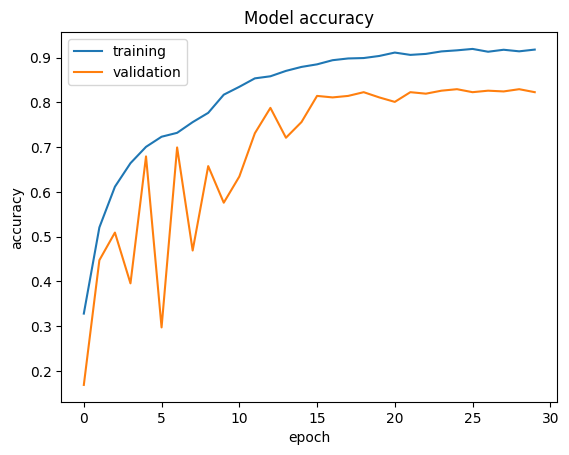

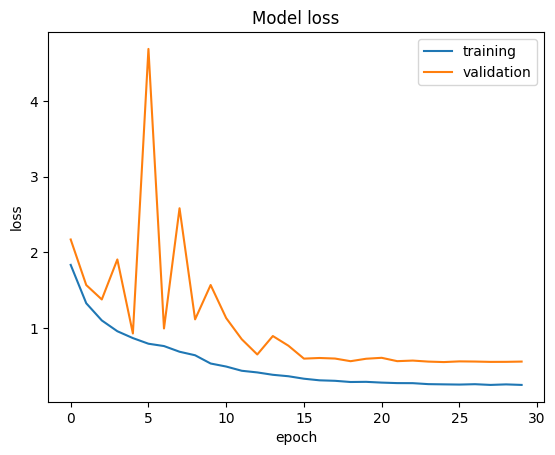

In [30]:
# NOTE: Give following argument as `csv_logger.csv_file.name` if you want to use the recently saved training history
history = read_logs('storage/trainingLogs/genreClassificationTraining' + id_strings['melspectrogram_model'] + '.log')
plot_model_history(history) # Function available in `ImportsForModelHandling.ipynb`